# Parallel Computing of PDE Control Problem

In this notebook, we solve a large-scale parallel optimization of the problem specified in baseline_functionality.ipynb.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import dblquad, trapezoid
from tqdm import tqdm
import os
# import cvxpy as cp
from system_response import system_response
from multiprocess import Pool
from matplotlib import cm
from matplotlib.colors import LogNorm   


In [65]:
###################################### local parameters ######################################
#  domain
xmin = -2
xmax = 2
ymin = -2
ymax = 2

# period for basis functions
lambda_1 = 2*(xmax - xmin)
lambda_2 = 2*(ymax - ymin)

# matrix norm
p = 2

# time steps
T  = 4
dt = 0.1

# number of controllers
n_u      = 16 # select perfect square
sqrt_n_u = int(np.sqrt(n_u)) 

# number of basis functions for approximation
k = 12

# radius of support of a(z) and b(z)
r = 0.5

# cost function parameters
Q = 1
R = 0


####################################### global parameters ######################################
factorScaleUp = 4 # number of patches in each direction 




In [66]:
# locations of controllers evenly spaced in the domain not on the boundary
u_loc_x = np.linspace(xmin, xmax, sqrt_n_u + 1)[0:-1] + (xmax - xmin)/(2*sqrt_n_u) 
u_loc_y = np.linspace(ymin, ymax, sqrt_n_u + 1)[0:-1] + (ymax - ymin)/(2*sqrt_n_u)
u_loc   = np.array([[x, y] for x in u_loc_x for y in u_loc_y])

# save uloc to file as npy
np.save('u_loc.npy', u_loc)



In [67]:
Nx = 30 # number of points in space to evaluate
z_tilde_x = np.linspace(xmin, xmax, Nx) 
z_tilde_y = np.linspace(ymin, ymax, Nx) 
z_tilde   = np.array([[x+np.random.randn()*0.01,
                        y+np.random.randn()*0.01] for x in z_tilde_x for y in z_tilde_y])



In [68]:
# function to approximate
def a(x, radius=r,p=p):
    mag_x = np.linalg.norm(x,p)
    if mag_x < radius:
        return 0.5*np.cos(np.pi*mag_x/radius) + 0.5
    else:
        return 0

# trig functions
def sin_sin_integrand_a(x1, x2, i, j):
    x = np.array([x1, x2])
    return a(x, radius=r) * np.sin(np.pi * 2*i * x1 / lambda_1) * np.sin(np.pi * 2*j * x2 / lambda_2)

def cos_sin_integrand_a(x1, x2, i, j):
    x = np.array([x1, x2])
    return a(x, radius=r) * np.cos(np.pi * 2*i * x1 / lambda_1) * np.sin(np.pi * 2*j * x2 / lambda_2)

def sin_cos_integrand_a(x1, x2 , i, j):
    x = np.array([x1, x2])
    return a(x, radius=r) * np.sin(np.pi * 2*i * x1 / lambda_1) * np.cos(np.pi * 2*j * x2 / lambda_2)

def cos_cos_integrand_a(x1, x2, i, j):
    x = np.array([x1, x2])
    return a(x, radius=r) * np.cos(np.pi * 2*i * x1 / lambda_1) * np.cos(np.pi * 2*j * x2 / lambda_2)


# compute coefficients if file doesn't exist
if not os.path.exists('coeffs_k{}_r05.npy'.format(k)):
    coeffs = np.zeros((k, k, 4))
    for kk in tqdm(range(k)):
        for jj in range((k)):
            if kk == 0 and jj == 0:
                kappa = 1
            elif kk == 0 or jj == 0:
                kappa = 2
            else:
                kappa = 4
            coeffs[kk, jj, 0] = dblquad(sin_sin_integrand_a, xmin, xmax, ymin, ymax, args=(kk, jj))[0] * kappa / (lambda_1 * lambda_2)
            coeffs[kk, jj, 1] = dblquad(cos_sin_integrand_a, xmin, xmax, ymin, ymax, args=(kk, jj))[0] * kappa / (lambda_1 * lambda_2)
            coeffs[kk, jj, 2] = dblquad(sin_cos_integrand_a, xmin, xmax, ymin, ymax, args=(kk, jj))[0] * kappa / (lambda_1 * lambda_2)
            coeffs[kk, jj, 3] = dblquad(cos_cos_integrand_a, xmin, xmax, ymin, ymax, args=(kk, jj))[0] * kappa / (lambda_1 * lambda_2)

    np.save('coeffs_k{}_r05.npy'.format(k), coeffs)
else:
    coeffs = np.load('coeffs_k{}_r05.npy'.format(k))

In [69]:
def b(z,loc,radius=r):
    return -a(z-loc,radius=radius)

# trig functions for b
def sin_sin_integrand(x1, x2, i, j):
    return np.sin(np.pi * 2*i * x1 / lambda_1) * np.sin(np.pi * 2*j * x2 / lambda_2)
def cos_sin_integrand(x1, x2, i, j):
    return np.cos(np.pi * 2*i * x1 / lambda_1) * np.sin(np.pi * 2*j * x2 / lambda_2)
def sin_cos_integrand(x1, x2 , i, j):
    return np.sin(np.pi * 2*i * x1 / lambda_1) * np.cos(np.pi * 2*j * x2 / lambda_2)
def cos_cos_integrand(x1, x2, i, j):
    return np.cos(np.pi * 2*i * x1 / lambda_1) * np.cos(np.pi * 2*j * x2 / lambda_2)

# check if coeffs_b_k{}.npy exists
if not os.path.exists('coeffs_b_k{}_r05_nu{}.npy'.format(k,n_u)):
    coeffs_b = np.zeros((k, k, 4, n_u))
    for kk in tqdm(range(k)):
        for jj in range((k)):
            if kk == 0 and jj == 0:
                kappa = 1
            elif kk == 0 or jj == 0:
                kappa = 2
            else:
                kappa = 4
            for controller in range(n_u):
                coeffs_b[kk, jj, 0, controller] = dblquad(lambda x1, x2: sin_sin_integrand(x1, x2, kk, jj) * b(np.array([x1, x2]), u_loc[controller], radius=r), xmin, xmax, ymin, ymax)[0] * kappa / (lambda_1 * lambda_2)
                coeffs_b[kk, jj, 1, controller] = dblquad(lambda x1, x2: cos_sin_integrand(x1, x2, kk, jj) * b(np.array([x1, x2]), u_loc[controller], radius=r), xmin, xmax, ymin, ymax)[0] * kappa / (lambda_1 * lambda_2)
                coeffs_b[kk, jj, 2, controller] = dblquad(lambda x1, x2: sin_cos_integrand(x1, x2, kk, jj) * b(np.array([x1, x2]), u_loc[controller], radius=r), xmin, xmax, ymin, ymax)[0] * kappa / (lambda_1 * lambda_2)
                coeffs_b[kk, jj, 3, controller] = dblquad(lambda x1, x2: cos_cos_integrand(x1, x2, kk, jj) * b(np.array([x1, x2]), u_loc[controller], radius=r), xmin, xmax, ymin, ymax)[0] * kappa / (lambda_1 * lambda_2)

    np.save('coeffs_b_k{}_r05_nu{}.npy'.format(k,n_u), coeffs_b)

else: # if it exists, load it
    coeffs_b = np.load('coeffs_b_k{}_r05_nu{}.npy'.format(k,n_u))

In [70]:
%%writefile system_response.py

import numpy as np
import cvxpy as cp
import time

def system_response(inputs_):
    start_time = time.time()
    z,coeffs,coeffs_b,u_loc,k,n_u,T,r,lambda_1,lambda_2,xmin,xmax,ymin,ymax,Q,R = inputs_

    # recenter z and u_loc inside the domain
    # central controller is at (0,0)
    x_mean = np.mean(u_loc[:,0])
    y_mean = np.mean(u_loc[:,1])
    z[0] = z[0] - x_mean
    z[1] = z[1] - y_mean
    u_loc[:,0] = u_loc[:,0] - x_mean
    u_loc[:,1] = u_loc[:,1] - y_mean

    alpha   = cp.Variable((T,k*k*4))
    utilde  = cp.Variable((T,n_u))

    # round coeffs and coeffs_b to 15 decimal places
    coeffs   = np.round(coeffs, 15) # a_{mni}
    coeffs_b = np.round(coeffs_b, 15) # b_{mnil}

    # constraints
    constraints = []

    for m in range(k):
        for n in range(k):
            # (m,n)^th basis function
            sinsin = np.sin(np.pi * 2*m * z[0] / lambda_1) * np.sin(np.pi * 2*n * z[1] / lambda_2) 
            cossin = np.cos(np.pi * 2*m * z[0] / lambda_1) * np.sin(np.pi * 2*n * z[1] / lambda_2) 
            sincos = np.sin(np.pi * 2*m * z[0] / lambda_1) * np.cos(np.pi * 2*n * z[1] / lambda_2)
            coscos = np.cos(np.pi * 2*m * z[0] / lambda_1) * np.cos(np.pi * 2*n * z[1] / lambda_2) 
            current_idx_set = np.arange(m*k*4 + n*4, m*k*4 + n*4 + 4)
            for i in range(4): # each type of trig function combination
                idx = m*k*4 + n*4 + i
                sublist = []
                ################################ initial condition ################################
                initial_coeff = 0
                if i==0:
                    # sin(z[0])sin(z[1])
                    initial_coeff = coscos*coeffs[m,n,0] + sincos*coeffs[m,n,1] + cossin*coeffs[m,n,2] + sinsin*coeffs[m,n,3]
                elif i==1:
                    # cos(z[0])sin(z[1])
                    initial_coeff = -sincos*coeffs[m,n,0] + coscos*coeffs[m,n,1] - sinsin*coeffs[m,n,2] + cossin*coeffs[m,n,3]
                elif i==2:
                    # sin(z[0])cos(z[1])
                    initial_coeff = -cossin*coeffs[m,n,0] - sinsin*coeffs[m,n,1] + coscos*coeffs[m,n,2] + sincos*coeffs[m,n,3]
                else:
                    # cos(z[0])cos(z[1])
                    initial_coeff = sinsin*coeffs[m,n,0] - cossin*coeffs[m,n,1] - sincos*coeffs[m,n,2] + coscos*coeffs[m,n,3]
                    
                sublist  += [coeffs_b[m,n,i,:] @ utilde[0,:] + np.copy(initial_coeff) == alpha[0,idx]]
                ######################################################################################


                ################################ dynamics ################################
                # \[Pi] (\[Pi] Sin[v] ((-b f-a g+d h+c j) Cos[z]+(d f+c g+b h+a j) Sin[z])+\[Pi] Cos[v] ((a f-b g-c h+d j) Cos[z]+(-c f+d g-a h+b j) Sin[z])) 
                for t in range(T-1):
                    new_coeff = 0
                    if i==0: # sin(z[0])sin(z[1])    (d f+c g+b h+a j)
                        new_coeff = coeffs[m,n,3]*alpha[t,current_idx_set[0]] + coeffs[m,n,2]*alpha[t,current_idx_set[1]] + coeffs[m,n,1]*alpha[t,current_idx_set[2]] + coeffs[m,n,0]*alpha[t,current_idx_set[3]]
                    elif i==1: # cos(z[0])sin(z[1])    (-c f+d g-a h+b j)
                        new_coeff = -coeffs[m,n,2]*alpha[t,current_idx_set[0]] + coeffs[m,n,3]*alpha[t,current_idx_set[1]] - coeffs[m,n,0]*alpha[t,current_idx_set[2]] + coeffs[m,n,1]*alpha[t,current_idx_set[3]]
                    elif i==2: # sin(z[0])cos(z[1])    (-b f-a g+d h+c j)
                        new_coeff = -coeffs[m,n,1]*alpha[t,current_idx_set[0]] - coeffs[m,n,0]*alpha[t,current_idx_set[1]] + coeffs[m,n,3]*alpha[t,current_idx_set[2]] + coeffs[m,n,2]*alpha[t,current_idx_set[3]]
                    else: # cos(z[0])cos(z[1])    (a f-b g-c h+d j)
                        new_coeff = coeffs[m,n,0]*alpha[t,current_idx_set[0]] - coeffs[m,n,1]*alpha[t,current_idx_set[1]] - coeffs[m,n,2]*alpha[t,current_idx_set[2]] + coeffs[m,n,3]*alpha[t,current_idx_set[3]]
                    
                    sublist += [alpha[t+1,idx] - lambda_1*lambda_2/4* new_coeff- coeffs_b[m,n,i,:] @ utilde[t+1,:] == 0]
                ###############################################################################

                
                constraints += [sublist]
    
    # concatente all constraints for new variable
    global_constraints = [item for sublist in constraints for item in sublist]
    objective = cp.Minimize(Q*cp.sum_squares(alpha) + R*cp.sum_squares(utilde)) 
    prob = cp.Problem(objective, global_constraints)

    # don't use MOSEK in parallel
    prob.solve(verbose=False)

    # print time required to solve
    solve_time =  time.time() - start_time

    if prob.status == cp.OPTIMAL:
        # compute the response
        # reshape parameters
        alpha_parsed = alpha.value.reshape((T,k,k,4), order='C')

        # compute the approximation of the function at z_tilde
        x = np.linspace(xmin, xmax, 50)
        y = np.linspace(ymin, ymax, 50)
        X, Y = np.meshgrid(x, y)
        Z = np.zeros((T, X.shape[0], X.shape[1]))
        for tt in range(T):
            for i in range(k):
                for j in range(k):
                    for m in range(X.shape[0]):
                        for n in range(X.shape[1]):
                            Z[tt,m,n] += alpha_parsed[tt,i,j,0] * np.sin(np.pi * 2*i * X[m,n] / lambda_1) * np.sin(np.pi * 2*j * Y[m,n] / lambda_2) 
                            Z[tt,m,n] +=  alpha_parsed[tt,i,j,1] * np.cos(np.pi * 2*i * X[m,n] / lambda_1) * np.sin(np.pi * 2*j * Y[m,n] / lambda_2) 
                            Z[tt,m,n] +=  alpha_parsed[tt,i,j,2] * np.sin(np.pi * 2*i * X[m,n] / lambda_1) * np.cos(np.pi * 2*j * Y[m,n] / lambda_2) 
                            Z[tt,m,n] += alpha_parsed[tt,i,j,3] * np.cos(np.pi * 2*i * X[m,n] / lambda_1) * np.cos(np.pi * 2*j * Y[m,n] / lambda_2) 
        return Z, utilde.value,solve_time
    else:
        return np.zeros_like(X), np.zeros((T,n_u)), 0


Overwriting system_response.py


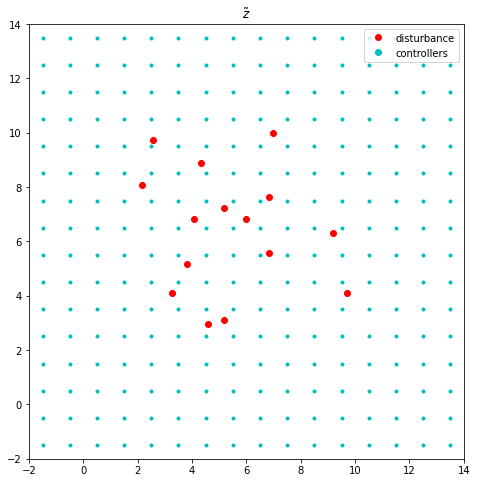

In [71]:
# select 5 random points in the scaled-up domain
Nw              = 15
disturbance_idx = np.random.randint(0, Nx*Nx, Nw)
random_scaling = [(np.random.choice(factorScaleUp-2)+1,np.random.choice(factorScaleUp-2)+1) for i in range(Nw)]
disturbance_points = z_tilde[disturbance_idx]
disturbance_points_scaled =np.array( [[disturbance_points[x,0]+(xmax-xmin)*random_scaling[x][0],
                                         disturbance_points[x,1]+(ymax-ymin)*random_scaling[x][1]] for x in range(Nw)] )

all_controllers = np.zeros((n_u*factorScaleUp*factorScaleUp,2))
# plot the points in space
idx = 0
plt.figure(figsize=(8,8))
for kk in range(factorScaleUp): # plot controllers
    for jj in range(factorScaleUp):
        all_controllers[n_u*idx : n_u*(idx+1) ,:] = u_loc + np.array([(xmax-xmin)*kk, (ymax-ymin)*jj]).T
        idx += 1
        plt.plot(u_loc[:,0]+(xmax-xmin)*kk, u_loc[:,1]+(ymax-ymin)*jj, 'co',markersize=3)
plt.plot(disturbance_points_scaled[:,0], disturbance_points_scaled[:,1], 'ro',label='disturbance')
plt.plot(np.nan, np.nan, 'co',label='controllers') # make legend handle for controllers
plt.xlim(xmin, xmax+(factorScaleUp-1)*(xmax-xmin))
plt.ylim(ymin, ymax+(factorScaleUp-1)*(ymax-ymin))
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.title(r'$\tilde{z}$')
plt.show()

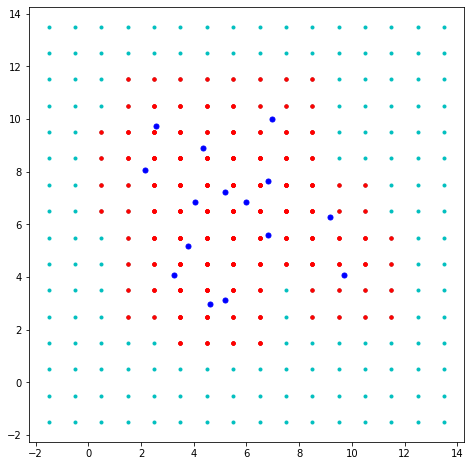

In [72]:
# for each disturbance_point_scaled, compute controllers within lambda_x/4 or lambda_y/4
local_controllers = []
for i in range(Nw):
    local_controllers.append(np.vstack([controller for controller in all_controllers \
                               if np.abs(controller[0] - disturbance_points_scaled[i][0]) < lambda_1/4 and \
                                  np.abs(controller[1] - disturbance_points_scaled[i][1]) < lambda_2/4]))

# plot all controllers
plt.figure(figsize=(8,8))
plt.plot(all_controllers[:,0], all_controllers[:,1], 'co',markersize=3)
for i in range(Nw):
    plt.plot(local_controllers[i][:,0], local_controllers[i][:,1], 'ro',markersize=3.5)
plt.plot(disturbance_points_scaled[:,0], disturbance_points_scaled[:,1], 'bo',markersize=5.)
# make square
plt.gca().set_aspect('equal', adjustable='box')

In [73]:

input_list = [(disturbance_points_scaled[w_idx],
               coeffs,
               coeffs_b,
               local_controllers[w_idx],
               k,
               n_u,
               T,
               r,
               lambda_1,
               lambda_2,
               xmin,
               xmax,
               ymin,
               ymax,
               Q,
               R ) for w_idx in range(Nw)]

max_pool = 8
with Pool(max_pool) as p:
    pool_outputs = list(
        tqdm(
            p.imap(system_response,
                   input_list),
            total=len(input_list)
        )
    )    



100%|██████████| 15/15 [02:06<00:00,  8.40s/it]


In [74]:
for i in range(len(pool_outputs)):
    np.save('CLM_{}_control.npy'.format(i), pool_outputs[i][1])
    np.save('CLM_{}_response.npy'.format(i), pool_outputs[i][0])


In [96]:
# pool_outputs[0][2] # time to solve
pool_outputs[10][1][3]

array([ 5.37197906e-06, -5.13431313e-05, -3.79163551e-05,  4.25910319e-06,
       -4.49942716e-05,  3.54318451e-04,  1.35896263e-04, -4.47428628e-05,
       -5.40954474e-05,  4.18605181e-04,  2.08282460e-04, -4.83295774e-05,
        6.49781708e-06, -5.59572212e-05, -3.70884432e-05,  4.70109706e-06])

(102, 2)


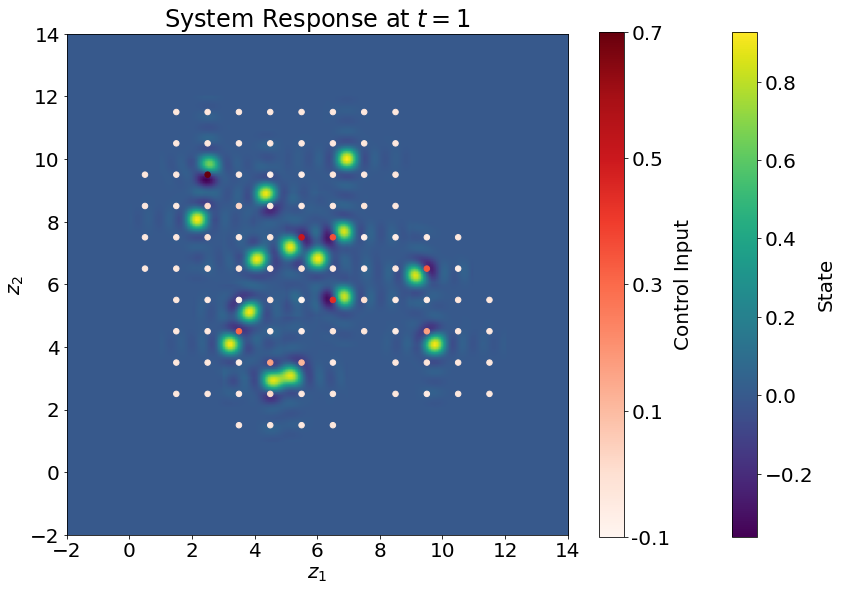

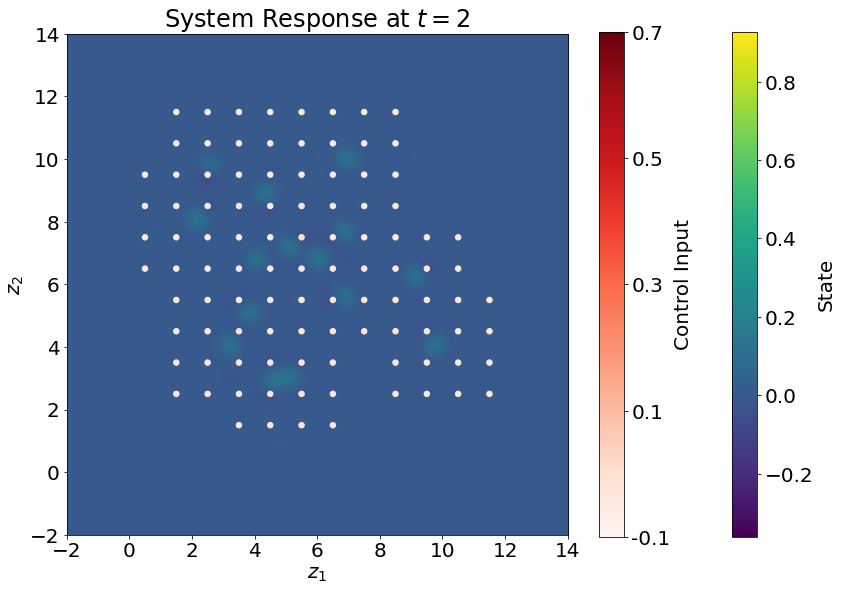

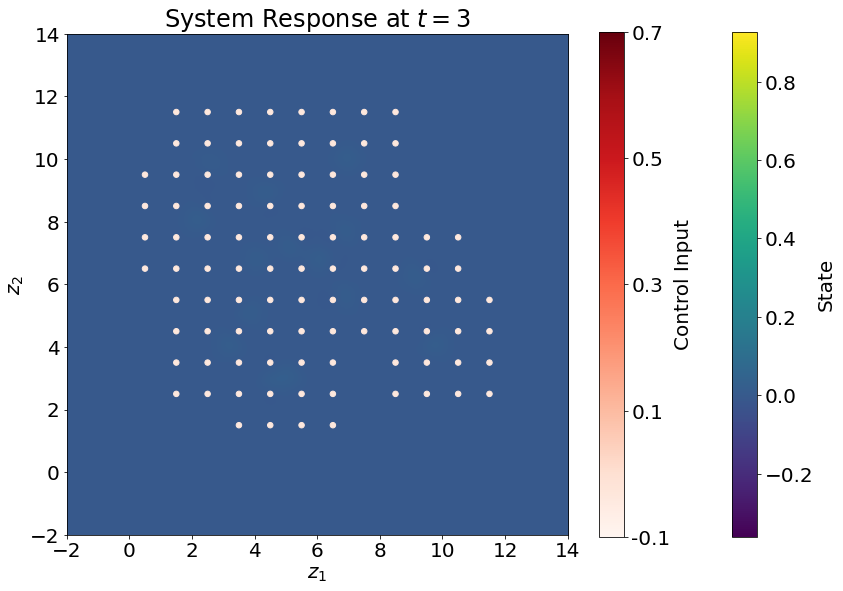

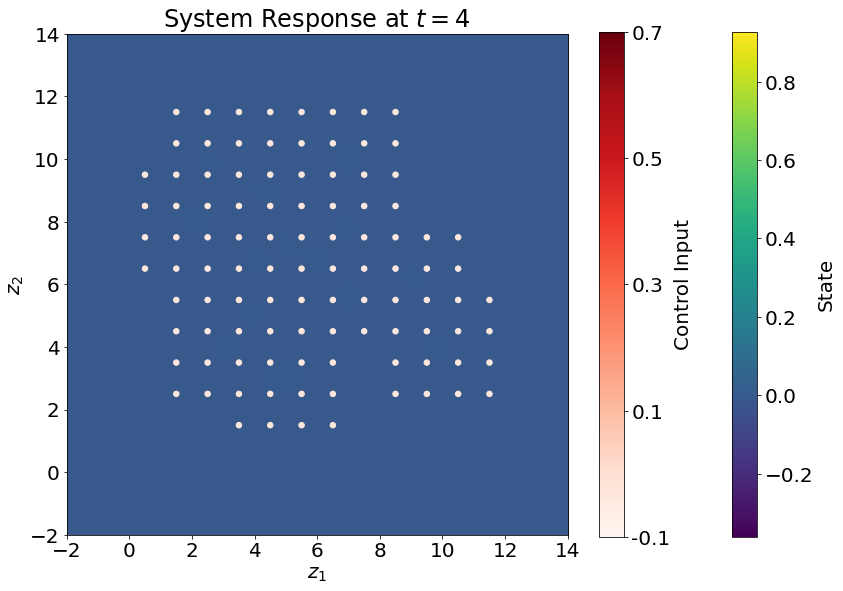

In [112]:
# patch together the responses and plot them
fontsize = 20 
# cmap = cm.get_cmap('Wistia')
cmap = cm.get_cmap('Reds')
chunkSize = 50
Z = np.zeros((T, factorScaleUp*chunkSize, factorScaleUp*chunkSize))
dx = (xmax - xmin)/chunkSize
# make list of unique controllers
unique_controllers = np.unique(np.vstack(local_controllers), axis=0)
print(unique_controllers.shape)
controller_vals    = np.zeros((unique_controllers.shape[0],T))
for ii in range(Nw):
    loc = disturbance_points_scaled[ii]
    loc_ctrl = local_controllers[ii]
    # get bottom left controller
    min_y_coord = np.min(loc_ctrl[:,0]) - (xmax - xmin)/(2*sqrt_n_u) - xmin # - (xmax - xmin)/(sqrt_n_u + 1)
    min_x_coord = np.min(loc_ctrl[:,1]) - (ymax - ymin)/(2*sqrt_n_u) - ymin  #- (ymax - ymin)/(sqrt_n_u + 1)
    x_idx       = int(min_x_coord/dx)
    y_idx       = int(min_y_coord/dx)
    Z[:,x_idx:x_idx+chunkSize, y_idx:y_idx+chunkSize] += np.load('CLM_{}_response.npy'.format(ii))

    # get indices of controllers
    ctrl_idx = np.array([np.where(np.all(unique_controllers == controller, axis=1))[0][0] for controller in loc_ctrl])
    controller_vals[ctrl_idx,:] += np.load('CLM_{}_control.npy'.format(ii)).T


# plot based on T
cmin = np.min(Z)
cmax = np.max(Z)
vmin = np.min(controller_vals)
vmax = np.max(controller_vals)
for tt in range(T):
    plt.figure(figsize=(12,12))
    plt.imshow(Z[tt,:,:], 
               extent= [xmin, 
                        xmax+(factorScaleUp-1)*(xmax-xmin), 
                        ymin, 
                        ymax+(factorScaleUp-1)*(ymax-ymin)], 
                        origin='lower',
                        vmin=cmin,
                        vmax=cmax)
    cb1 = plt.colorbar(shrink=0.6)
    cb1.set_label('State',fontsize=fontsize)
    cb1.ax.tick_params(labelsize=fontsize)
    plt.scatter( unique_controllers[:,0],
                unique_controllers[:,1],
                c=controller_vals[:,tt],
                cmap=cmap,
                s=30,
                vmin=vmin,
                vmax=vmax) #,norm=LogNorm(vmin=vmin,vmax=vmax)) # Reds
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cb2 = plt.colorbar(sm, ticks=np.linspace(vmin, vmax, 5),shrink=0.6,
                format="%.1f")
    cb2.set_label('Control Input',fontsize=fontsize)
    cb2.ax.tick_params(labelsize=fontsize)
    plt.title("System Response at $t={}$".format(tt+1),fontsize=fontsize+4)
    plt.xlabel(r'$z_1$',fontsize=fontsize)
    plt.ylabel(r'$z_2$',fontsize=fontsize)
    ax = plt.gca()
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    plt.tight_layout()
    plt.savefig('CLM_distributed_t{}.png'.format(tt))
    plt.show()
